In [117]:
from packaging import version
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os
import scipy
from collections import defaultdict
from functools import partial
from  matplotlib.ticker import FuncFormatter
import torch
import numpy as np

In [118]:
def load_exp(exp_name):
    dir_path = Path(
        "/home/xt0r3-user/cambridge/partii/dissertation/s3prl/s3prl/s3prl/result/downstream/"
    )

    if not (dir_path / exp_name / "log.log").exists():
        return {}

    with open(dir_path / exp_name / "log.log") as f:

        test_metrics = {}

        for line in f:
            if line.startswith("mdd/test"):
                metrics_list = line.strip().split("|")[1:-1]
                epoch_metrics = dict(
                    [tuple(metric_pair.split(":")) for metric_pair in metrics_list]
                )
                step  =int(epoch_metrics['step']) 
                if step not in test_metrics and step > 0:
                    test_metrics[step] = epoch_metrics

    return test_metrics
    # sns.lineplot(dfx, x='step', y='value', hue='name', errorbar=None)

In [119]:
results = {}
exps = [
    'kan_wav2vec2',
    'kan_layernorm_wav2vec2',
    'model_wav2vec2',
]
for i in range(1, 5):
    for exp in exps:
        exp_name = f'{exp}_{i}'
        exp_log = load_exp(exp_name)
        if len(exp_log) > 0:
            results[exp_name] = exp_log

df = pd.json_normalize(results)
df.columns = pd.MultiIndex.from_tuples(df.columns.str.split('.').to_series().apply(tuple).apply(lambda t: (*t, t[0][:-2])))
df = df.stack(1).droplevel(0, axis=0).astype(float)
df = df.swaplevel(0, 1, axis=1)
df = df.rename_axis('step', axis=0)
df.index = df.index.astype(int)
df = df.sort_index()


In [120]:

sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=2, color_codes=False, rc=None)

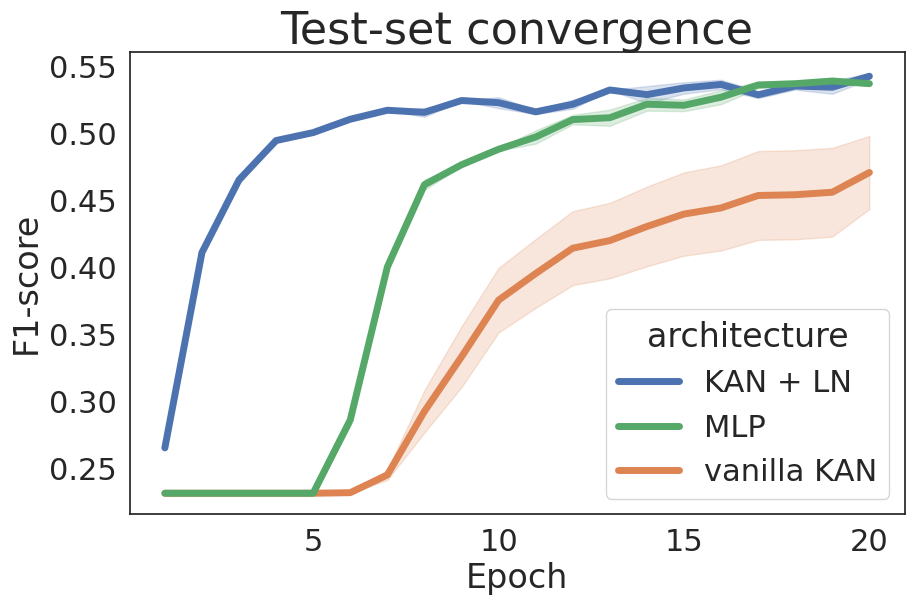

In [122]:
plt.figure(figsize=(10, 6))
dfx = df["global-f1-score"].droplevel(axis=1, level=0)
dfx.index = dfx.index.to_series() / 89
ax = sns.lineplot(
    dfx,
    errorbar="se",
    linewidth=5,
    legend=False,
)
for line in [ax.lines[0], ax.lines[2], ax.lines[1]]:
    line.set_linestyle("-")

ax.legend(
    [ax.lines[0], ax.lines[2], ax.lines[1]],
    [
        "KAN + LN",
        "MLP",
        "vanilla KAN",
    ],
    title="architecture",
    loc=0
)

plt.title("Test-set convergence", fontsize=32)
plt.ylabel("F1-score")
plt.xlabel("Epoch")

plt.savefig("kan_convergence.png", bbox_inches="tight", dpi=300)